
⚗: 😉
**Proyecto ML Final, Sistema de Recomendación de Películas**

---
Por:
Gerardo Ríos (jose.g.rios@unl.edu.ec)
Israel León (israel.leon@unl.edu.ec)


1. Carga de librerías y de datos

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
pip install fuzzywuzzy

In [ ]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import joblib

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


**LOAD DATA**

In [ ]:
df_movies = pd.read_csv(
    os.path.join('/content/drive/MyDrive/ProyectoSistemadeRecomendación', "movies.csv"),
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    os.path.join('/content/drive/MyDrive/ProyectoSistemadeRecomendación', "ratingsSmall.csv"),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [ ]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int32 
 1   title    58098 non-null  object
dtypes: int32(1), object(1)
memory usage: 681.0+ KB


In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503907 entries, 0 to 503906
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   503907 non-null  int32  
 1   movieId  503907 non-null  int32  
 2   rating   503907 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 5.8 MB


In [ ]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [ ]:
df_ratings.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [ ]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('Hay {} usuarios únicos y {} películas únicas en el dataset'.format(num_users, num_items))

Hay 5132 usuarios únicos y 17859 películas únicas en el dataset


***ANÁLISIS EXPLORATORIO DE DATOS***

1. Graficar los conteos de cada calificación

primero tenemos que obtener los recuentos de cada valoración de los datos de las valoraciones

In [ ]:
# obtener conteo
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,7616
1.0,16070
1.5,8074
2.0,34241
2.5,24832
3.0,101348
3.5,62811
4.0,132594
4.5,43729


Podemos ver que la tabla anterior no incluye recuentos de puntuación de calificación cero. Entonces, también debemos agregar eso en el marco de datos de conteo de calificaciones

In [ ]:
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# agregar recuentos de calificación cero a df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,91148481
0.5,7616
1.0,16070
1.5,8074
2.0,34241
2.5,24832
3.0,101348
3.5,62811
4.0,132594
4.5,43729


El conteo de la puntuación de cero es demasiado grande para compararlo con los demás. Así que vamos a tomar la transformación logarítmica para los valores de conteo y luego podemos trazarlos para comparar

In [ ]:
# Añadir conteo logarítmico
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,91148481,18.328000
0.5,7616,8.938007
1.0,16070,9.684709
1.5,8074,8.996404
2.0,34241,10.441179
2.5,24832,10.119888
3.0,101348,11.526315
3.5,62811,11.047885
4.0,132594,11.795047
4.5,43729,10.685767


Text(0, 0.5, 'número de calificaciones')

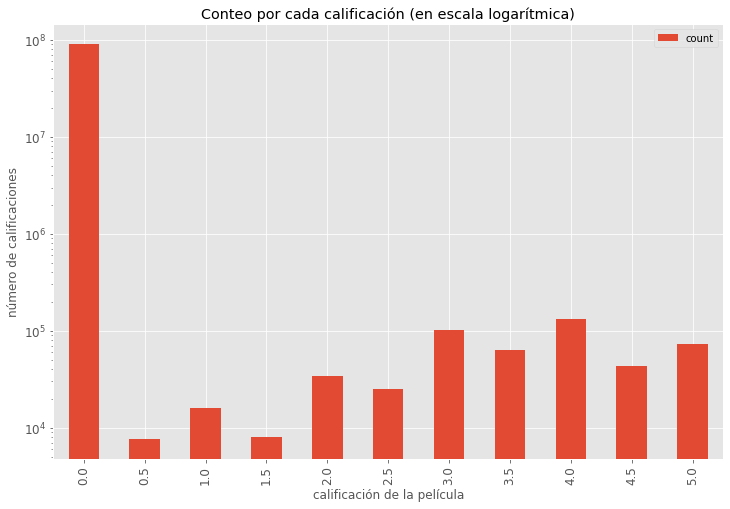

In [ ]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Conteo por cada calificación (en escala logarítmica)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("calificación de la película")
ax.set_ylabel("número de calificaciones")

Es interesante que hay más personas que otorgan puntajes de calificación de 3 y 4 que otros puntajes.

***Frecuencia de calificación de todas las películas.***

In [ ]:
df_ratings.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [ ]:
# obteniendo la freciencia de los ratings
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,1244
2,478
3,293
4,64
5,281


Text(0, 0.5, 'número de calificaciones')

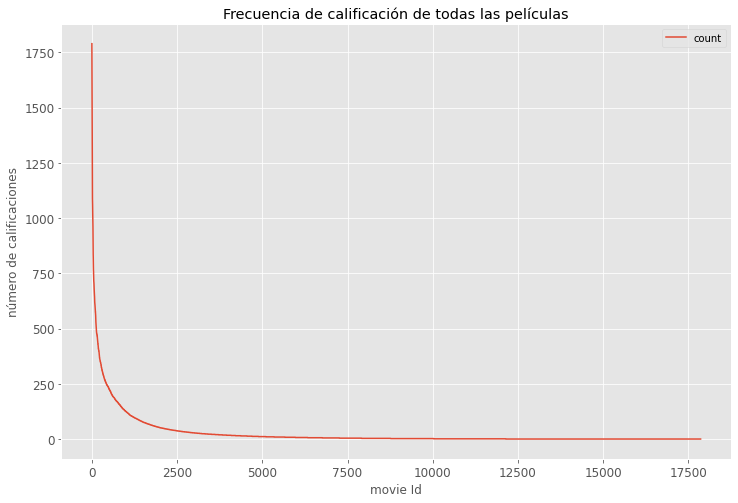

In [ ]:
# graficar  frecuencia de ratings de todas las peliculas 
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Frecuencia de calificación de todas las películas',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("número de calificaciones")

La distribución de las puntuaciones entre las películas suele satisfacer una propiedad en el mundo real, que se denomina propiedad de cola larga. Según esta propiedad, sólo una pequeña fracción de los artículos se califica con frecuencia. Estos elementos se denominan elementos populares. La gran mayoría de los artículos se valoran con poca frecuencia. Esto da lugar a una distribución muy sesgada de las valoraciones subyacentes.

Trazamos la misma distribución pero con escala logarítmica

Grafiquemos la misma distribución pero con escala logarítmica

Text(0, 0.5, 'número de calificaciones (escala logarítmica)')

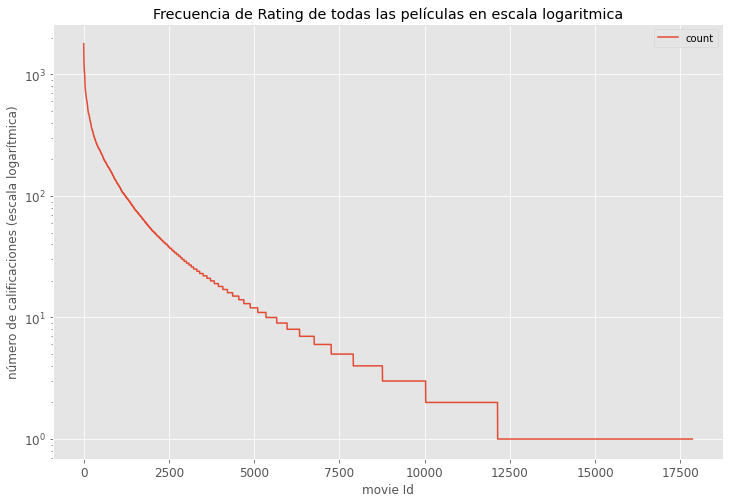

In [ ]:
# Grafica de la frecuencia de ratings en escala logaritmica 
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Frecuencia de Rating de todas las películas en escala logaritmica',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("número de calificaciones (escala logarítmica)")

Podemos ver que aproximadamente 10 000 de 53 889 películas tienen más de 100 calificaciones. Más interesante aún, aproximadamente 20 000 de 53 889 películas tienen menos de 10 calificaciones. Miremos más de cerca mostrando los cuantiles superiores de recuentos de calificación

In [ ]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    1789.0
0.95     141.0
0.90      62.0
0.85      34.0
0.80      22.0
0.75      15.0
0.70      10.0
0.65       8.0
Name: count, dtype: float64

Así, un 1% de las películas tiene aproximadamente 97.999 o más valoraciones, un 5% tiene 1.855 o más, y un 20% tiene 100 o más. Como tenemos tantas películas, nos limitaremos al 25% más popular. Este es un umbral arbitrario de popularidad, pero nos da unas 13.500 películas diferentes. Todavía tenemos una buena cantidad de películas para modelar. Hay dos razones por las que queremos filtrar a aproximadamente 13.500 películas en nuestro conjunto de datos.


In [ ]:
# filtrando la data
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('forma de los datos de calificaciones originales: ', df_ratings.shape)
print('forma de los datos de calificaciones después de dejar caer películas impopulares: ', df_ratings_drop_movies.shape)

forma de los datos de calificaciones originales:  (503907, 3)
forma de los datos de calificaciones después de dejar caer películas impopulares:  (392708, 3)


Después de descartar el 75 % de las películas en nuestro conjunto de datos, todavía tenemos un conjunto de datos muy grande. A continuación, podemos filtrar usuarios para reducir aún más el tamaño de los datos.

In [ ]:
# Obtener el numero de ratings dado por cada usuario
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,16
2,15
3,5
4,630
5,65


Text(0, 0.5, 'número de calificaciones')

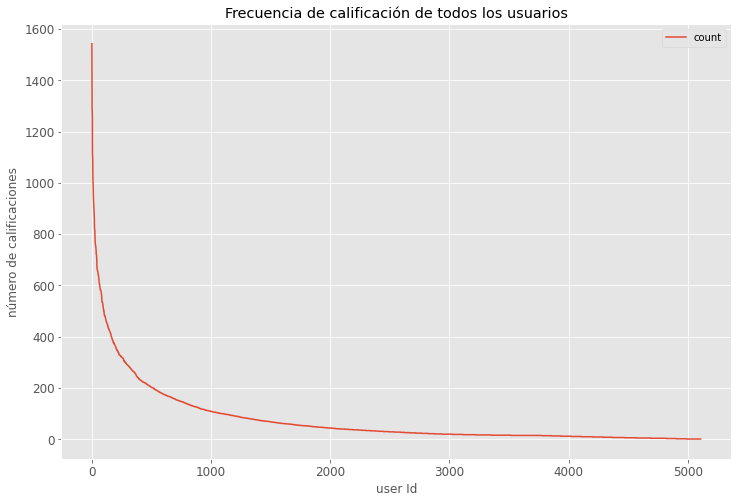

In [ ]:
# Grafica de frecuencia de clasificación de todas las películas
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Frecuencia de calificación de todos los usuarios',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("número de calificaciones")

In [ ]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    1543.00
0.95     317.65
0.90     201.00
0.85     145.00
0.80     106.00
0.75      84.00
0.70      66.00
0.65      53.00
0.60      42.00
0.55      34.00
Name: count, dtype: float64

Podemos ver que la distribución de las valoraciones de los usuarios es muy similar a la distribución de las valoraciones de las películas. Ambas tienen la propiedad de cola larga. Sólo una fracción muy pequeña de usuarios se dedica activamente a calificar las películas que ha visto. La gran mayoría de los usuarios no están interesados en calificar películas. Por lo tanto, podemos limitar los usuarios al 40% superior, que son unos 113.291 usuarios

In [ ]:
# filtrando la data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('forma de los datos de calificaciones originales: ', df_ratings.shape)
print('forma de los datos de calificaciones después de descartar tanto películas impopulares como usuarios inactivos: ', df_ratings_drop_users.shape)

forma de los datos de calificaciones originales:  (503907, 3)
forma de los datos de calificaciones después de descartar tanto películas impopulares como usuarios inactivos:  (333570, 3)


**3.-Entrenar el modelo KNN para el filtrado colaborativo basado en ítems**

* Reformulación de los datos
* Ajuste del modelo

1. Reformulación de los datos
Para los K-Nearest Neighbors, queremos que los datos estén en una matriz (artista, usuario), donde cada fila es una película y cada columna es un usuario diferente. Para remodelar el marco de datos, giraremos el marco de datos al formato ancho con las películas como filas y los usuarios como columnas. A continuación, rellenaremos las observaciones que faltan con 0s, ya que vamos a realizar operaciones de álgebra lineal (cálculo de distancias entre vectores). Por último, transformamos los valores del dataframe en una matriz sparse de scipy para que los cálculos sean más eficientes


In [ ]:
# pivotar y crear la matriz de usuario de la película
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# crear mapper del titulo de la pelicula a index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transformar la matriz en una matriz dispersa scipy
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**2. Ajuste de Modelo**

Es hora de implementar el modelo. Inicializaremos la clase NearestNeighbors como model_knn y ajustaremos nuestra matriz dispersa a la instancia. Al especificar la métrica = coseno, el modelo medirá la similitud entre los vectores de los artistas utilizando la similitud del coseno.

In [ ]:

# definir modelo
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# ajuste 
model_knn.fit(movie_user_mat_sparse)
joblib.dump(model_knn, '/home/modelo_entrenado.pkl')

['/home/modelo_entrenado.pkl']

***4. Uso del modelo entrenado para recomendar películas***

In [ ]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    Devuelve la coincidencia más cercana a través de una relación difusa. Si no se encuentra ninguna coincidencia, devuelve Ninguno
    
    Parameters
    ----------    
    mapper: dict, asigna el nombre del título de la película al índice de la película en los datos

    fav_movie: str, nombre de la película ingresada por el usuario
    
    verbose: bool, imprimir registro si es verdadero

    Retorna
    ------
    índice de la coincidencia más cercana
    """
    match_tuple = []
    # obtener coincidencias
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # ordenando
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('¡UPS! No se encuentra coincidencia')
        return
    if verbose:
        print('Encontrado posibles coincidencias en nuestra base de datos: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    Devuelve las mejores recomendaciones de películas similares basadas en la película de entrada del usuario

    Parametros
    ----------
    model_knn: modelo sklearn, modelo knn

    datos: matriz de película-usuario

    mapper: dict, asigna el nombre del título de la película al índice de la película en los datos

    fav_movie: str, nombre de la película ingresada por el usuario

    n_recomendaciones: int, n principales recomendaciones

    Return
    ------
    lista de las n mejores recomendaciones de películas similares
    """
    # Ajustar
    model_knn.fit(data)
    # obtener el índice de la película de entrada
    print('Tu película de entrada:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # Inferencia
    print('El sistema de recomendación comienza a hacer inferencias.')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # Obtener una lista de idx sin procesamiento de recomendaciones
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # Obtener mapeador inverso
    reverse_mapper = {v: k for k, v in mapper.items()}
    # Imprimir recomendaciones
    print('Recomendaciones para {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, con una distancia de {2}'.format(i+1, reverse_mapper[idx], dist))

In [ ]:
my_favorite = 'Scary Movie'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

Tu película de entrada: Scary Movie
Encontrado posibles coincidencias en nuestra base de datos: ['Scary Movie (2000)', 'Scary Movie 3 (2003)', 'Scary Movie 2 (2001)']

El sistema de recomendación comienza a hacer inferencias.
......

Recomendaciones para Scary Movie:
1: Ring, The (2002), con una distancia de 0.5859320759773254
2: Fast and the Furious, The (2001), con una distancia de 0.57155442237854
3: Me, Myself & Irene (2000), con una distancia de 0.571537971496582
4: Austin Powers in Goldmember (2002), con una distancia de 0.5694549679756165
5: Road Trip (2000), con una distancia de 0.567746639251709
6: Scary Movie 3 (2003), con una distancia de 0.5635279417037964
7: Bruce Almighty (2003), con una distancia de 0.5571568012237549
8: Final Destination (2000), con una distancia de 0.5545445680618286
9: Scary Movie 2 (2001), con una distancia de 0.4941127300262451
10: American Pie 2 (2001), con una distancia de 0.4852446913719177


**inspección adicional**

Veamos ahora qué tan escasa es la matriz de usuarios de películas calculando el porcentaje de valores cero en los datos.

In [ ]:
# calculo del número total de entradas en la matriz de usuarios de películas
num_entries = movie_user_mat.shape[0] * movie_user_mat.shape[1]
# calculo del número total de entradas con valores cero
num_zeros = (movie_user_mat==0).sum(axis=1).sum()
# calculo de la relación entre el número de ceros y el número de entradas
ratio_zeros = num_zeros / num_entries
print('Exiten alrededor de {:.2%} calificaciones de 0 en el dataset'.format(ratio_zeros))

Exiten alrededor de 91.38% calificaciones de 0 en el dataset


La gran mayoría de las entradas en nuestros datos es cero. Esto explica por qué la distancia entre elementos similares o elementos opuestos es bastante grande.

In [ ]:
#Para cargar el modelo entrenado:
model = joblib.load('/home/modelo_entrenado.plk')